### HW uplift-моделирования

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

Импортируем нужные библиотеки и предобработаем данные:

In [2]:
import pandas as pd; pd.set_option('display.max_columns', None)
df = pd.read_csv('data.csv')
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [3]:
df.rename(columns={'offer': 'treatment', 'conversion': 'target'}, inplace=True)

In [4]:
df['treatment'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [5]:
df.replace({'treatment': {'Buy One Get One': 1, 'Discount': 1, 'No Offer': 0}}, inplace=True)

In [6]:
df['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

In [7]:
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0


Категориальные признаки - zip_code и channel. Применим get_dummies.

In [8]:
df_main_1 = pd.concat([df, pd.get_dummies(df['zip_code'])],axis=1)
df_main = pd.concat([df_main_1, pd.get_dummies(df['channel'])],axis=1)
df_main.drop(['zip_code', 'channel'], axis=1, inplace=True)
df_main.head(3)

,recency,history,used_discount,used_bogo,is_referral,treatment,target,Rural,Surburban,Urban,Multichannel,Phone,Web
0,10,142.44,1,0,0,1,0,0,1,0,0,1,0
1,6,329.08,1,1,1,0,0,1,0,0,0,0,1
2,7,180.65,0,1,1,1,0,0,1,0,0,0,1


In [9]:
df_main.groupby("treatment")['target'].describe()

,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
0,21306.0,0.106167,0.308059,0.0,0.0,0.0,0.0,1.0
1,42694.0,0.167049,0.373024,0.0,0.0,0.0,0.0,1.0


In [10]:
from sklearn.model_selection import train_test_split

features = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral', 'Rural', 'Surburban', 'Urban', 'Multichannel', 'Phone', 'Web']
treatment = 'treatment'
target = 'target'

indices_train, indices_test = train_test_split(df_main.index, test_size=0.3, random_state=123)

In [11]:
X_train = df_main.loc[indices_train, features]
y_train = df_main.loc[indices_train, target]
treat_train = df_main.loc[indices_train, treatment]
X_test = df_main.loc[indices_test, features]
y_test = df_main.loc[indices_test, target]
treat_test = df_main.loc[indices_test, treatment]

Заведем переменные

In [12]:
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

#### C 1 моделью

In [13]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_test)
uplift_sm

array([ 0.0252381 , -0.05570183,  0.03155055, ...,  0.04443671,
        0.08677946,  0.01783349])

In [14]:
sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_10

0.09314527951524629

In [15]:
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)
sm_score_20

0.08719104142243063

In [16]:
models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

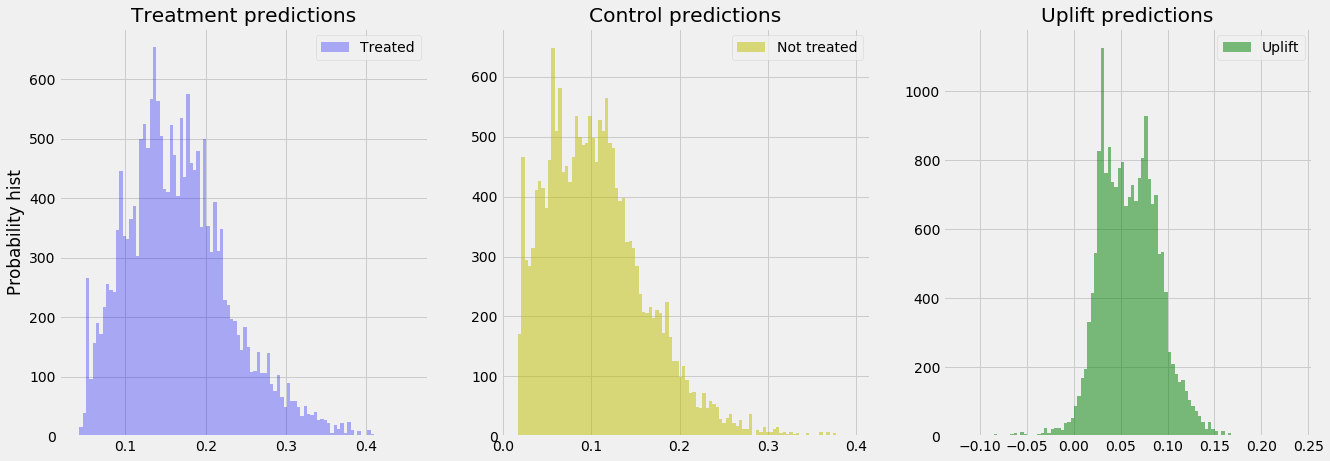

In [17]:
# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

Посмотрим на топ-признаки

In [18]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,17.506427
1,treatment,16.255747
2,history,15.471143
3,recency,14.464657
4,used_bogo,10.703624
5,used_discount,7.988503
6,Web,6.794430
7,Rural,6.018450
8,Urban,1.569307
9,Surburban,1.296216


#### 1.2 Трансформация классов

In [19]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.


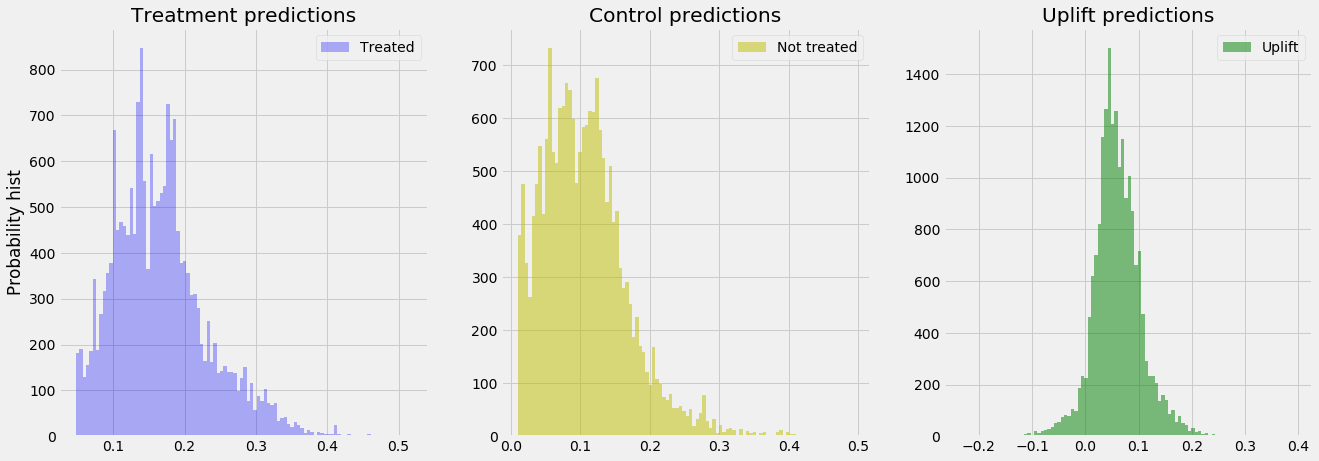

In [20]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

Посмотрим на результаты

In [21]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@10%,uplift@20%
0,SoloModel,0.093145,0.087191
2,TwoModels,0.085339,0.077817
1,ClassTransformation,0.072844,0.071572


#### Вариант с деревом решений

Wall time: 19.3 s


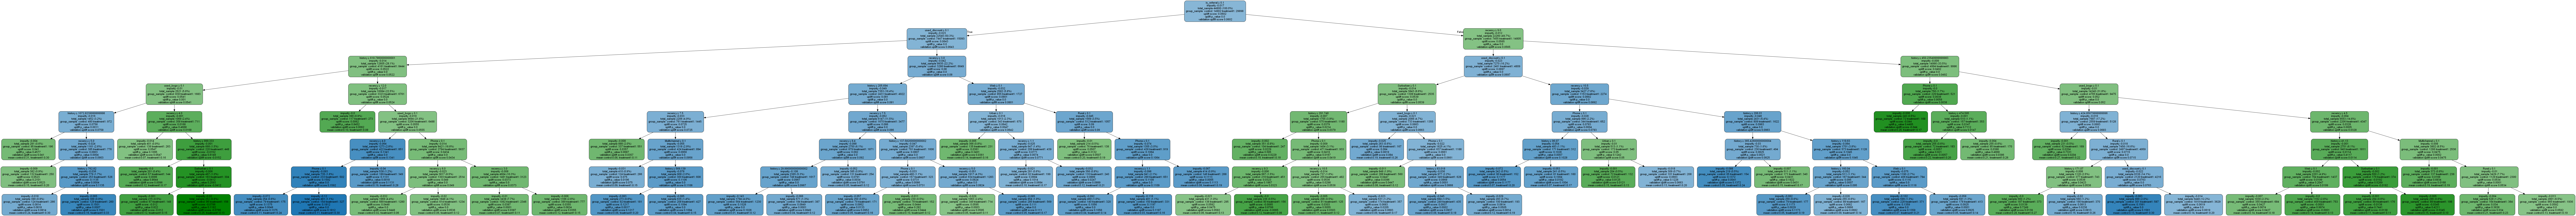

In [24]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

Средние значения mean control и treatment не выходили более 0.33

Один из интересных листов с mean control = 0.11 и mean treatment = 0.30, при p_value = 0, находился по цепочке:

is_referal >= 0.1; пользователи, которые пришли с реферальных каналов

used_discount >= 0.1; использовали скидки до этого

history < 618.78; стоимость исторических покупок

4 месяца < recency < 12 месяцев; время с последней покупки в пределах этих значений

used_bogo >= 0.1; уже пользовались акцией

phone < 0.1; и не используют для покупок телефон